# 0. Instalando dependências para o projeto


Caso esteje rodando o projeto pela primeira vez, execute os comandos para a instalação das libs abaixo

    python=3.10.13 utilizado no projeto

In [1]:
%%capture
%%time
%pip install pandas==2.2.2 numpy==1.26.4 matplotlib==3.8.4 seaborn==0.13.2 statsmodels==0.14.2 prophet==1.1.5

# 1. Imports

In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
from prophet import Prophet
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor

sns.set_style("darkgrid")
pd.set_option("display.max_columns",None)
pd.set_option("display.float_format", lambda x: "%.4f" % x)

# 2. Carregando dataset

In [3]:
dataset = pd.read_csv(
    "dados_operacoes.csv"
)
dataset.head()

,id,contrato,data_operacao,nascimento,idade,genero,bairro,cidade,estado,cep,telefone,cartao,email,ocupacao,empregador,operacao,valor_principal,parcelas,quantidade_parcelas,parcelas_pagas,quantidade_parcelas_pagas,taxa_contrato,valor_parcela,valor_bruto
0,682e8b505c30bb12052f9457516dc47e7eafc8ed,1760865030954,2019-09-13,1974-06-08,48,F,Conjunto Paulo Vi,Moreira,Rio de Janeiro,XXXXX-685,XXXXXXXXXXXXX2797,Null,XXXXa51@mXXXXXXXXXXXX,Espeleologista,e53d5342e82e0ce6061bc3aaea1a986f24a73613,Prod,27810.6900,100,100,20,20,1.4649,531.5600,53156.0000
1,45ad9d444a276407df8b6f47c0fcc5b127dadaaa,6023030871505,2022-11-03,1988-07-23,34,F,Minas Caixa,da Mota de Azevedo,Amapá,XXXXX735,Null,XXXXXXXXXX562960,XXXXXXXXXXXnda@tXXXXXXXXXXXX,Mágico,f715ffaf2c8294df43df3357c6a37f04b900fb06,Refin,9589.9600,40,40,6,6,4.5359,523.8200,20952.8000
2,81cec74ea2ca41535fee03daeb410ddbdf12906a,560263027614,2021-06-13,1975-08-17,Null,Null,Vila Mantiqueira,Rocha da Prata,Santa Catarina,XXXXX863,XXXXXXXXXXXXX1-3076,XXXXXXXXXX55,Null,Null,da9515ffa45dd12791be0941b91188e51fe1cc04,Prod,42963.2000,100,100,10,10,1.4475,815.7100,81571.0000
3,4e987d9178e2dcb07c2bf3878736233a676a0a87,1397061435926,2021-08-30,1982-08-17,40,F,Anchieta,da Mata,Null,Null,Null,Null,Null,Conferente de carga e descarga,0c1741dc26339e6af3e4b6badcf984d383d1ca44,Port + Refin,2954.1400,120,120,6,6,1.8290,60.9600,7315.1997
4,595943ecdb32a24ccb6ef374b6d865f3b60d7130,3823566005671,2022-11-16,1985-07-14,37,F,Conjunto Floramar,Moreira de Goiás,Mato Grosso,XXXXX384,XXXXXXXXXXXXX7089,Null,Null,Treinador,f97b240dc24290c19e717d7a654747aa31722ad3,Prod,31186.1700,100,100,10,10,3.2834,1066.1100,106611.0000


# 3. Análise exploratória de dados

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14895 entries, 0 to 14894
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         14895 non-null  object 
 1   contrato                   14895 non-null  int64  
 2   data_operacao              14895 non-null  object 
 3   nascimento                 14895 non-null  object 
 4   idade                      14895 non-null  object 
 5   genero                     14895 non-null  object 
 6   bairro                     14895 non-null  object 
 7   cidade                     14895 non-null  object 
 8   estado                     14895 non-null  object 
 9   cep                        14895 non-null  object 
 10  telefone                   14895 non-null  object 
 11  cartao                     14895 non-null  object 
 12  email                      14895 non-null  object 
 13  ocupacao                   14895 non-null  obj

In [5]:
print("Quantidade de nulos:\n",dataset.isna().sum())

Quantidade de nulos:
 id                           0
contrato                     0
data_operacao                0
nascimento                   0
idade                        0
genero                       0
bairro                       0
cidade                       0
estado                       0
cep                          0
telefone                     0
cartao                       0
email                        0
ocupacao                     0
empregador                   0
operacao                     0
valor_principal              0
parcelas                     0
quantidade_parcelas          0
parcelas_pagas               0
quantidade_parcelas_pagas    0
taxa_contrato                0
valor_parcela                0
valor_bruto                  0
dtype: int64


- Não existem dados nulos no conjunto de dados.

- Existem variáveis de natureza numérica e categóricas.

<p style="color:white; font-size:22px;"><p>O conjunto de dados que foi recebido não deixa explícito a nomenclatura da/ das coluna objetivo, portanto, abre espaço para minha interpretação: </p>

<p style="color:red; font-size:22px;">"Faça uma projeção do crescimento da carteira para os próximos 2 anos em termos de volume de operações e da carteira utilizando os métodos de ciência de dados que julgar mais adequados para essa tarefa"</p>
<p style="color:yellow; font-size:22px;">Segundo o texto, fica claro que é um problema de previsão de séries temporáis. No meu julgamento quando ele se refere à "crescimento da carteira para os próximos 2 anos em termos de volume de operações" se trata do número de operações totais realizadas naquela data, coluna "operacao" (abre possibilidade também para uma previsão a nível de "cliente", porém irei seguir com a primeira opção)<br><br>A segun objetivo é "valor_princial" (em minha interpretação), portanto, seguirei de maneira pareciada ao primeiro objetivo.</p>

Separando as variaveis baseado em seu tipos, para performarmos diferentes analises acerca delas.

In [6]:
# Convertendo idade para inteiro
dataset["idade"] = dataset["idade"].replace("Null", 0).astype(int)

In [7]:
# Separando em variáveis depentendes e independentes
X = dataset.drop(columns=["operacao", "valor_principal"])
y = dataset[["operacao", "valor_principal"]]

In [8]:
# Selecionando tipos de variáveis
variaveis_continuas = X.select_dtypes("float64").columns.tolist()
variaveis_discretas = X.select_dtypes("int64").columns.tolist()
variaveis_categoricas = X.select_dtypes("object").columns.tolist()

## 3.1 Analisando as variaveis continuas

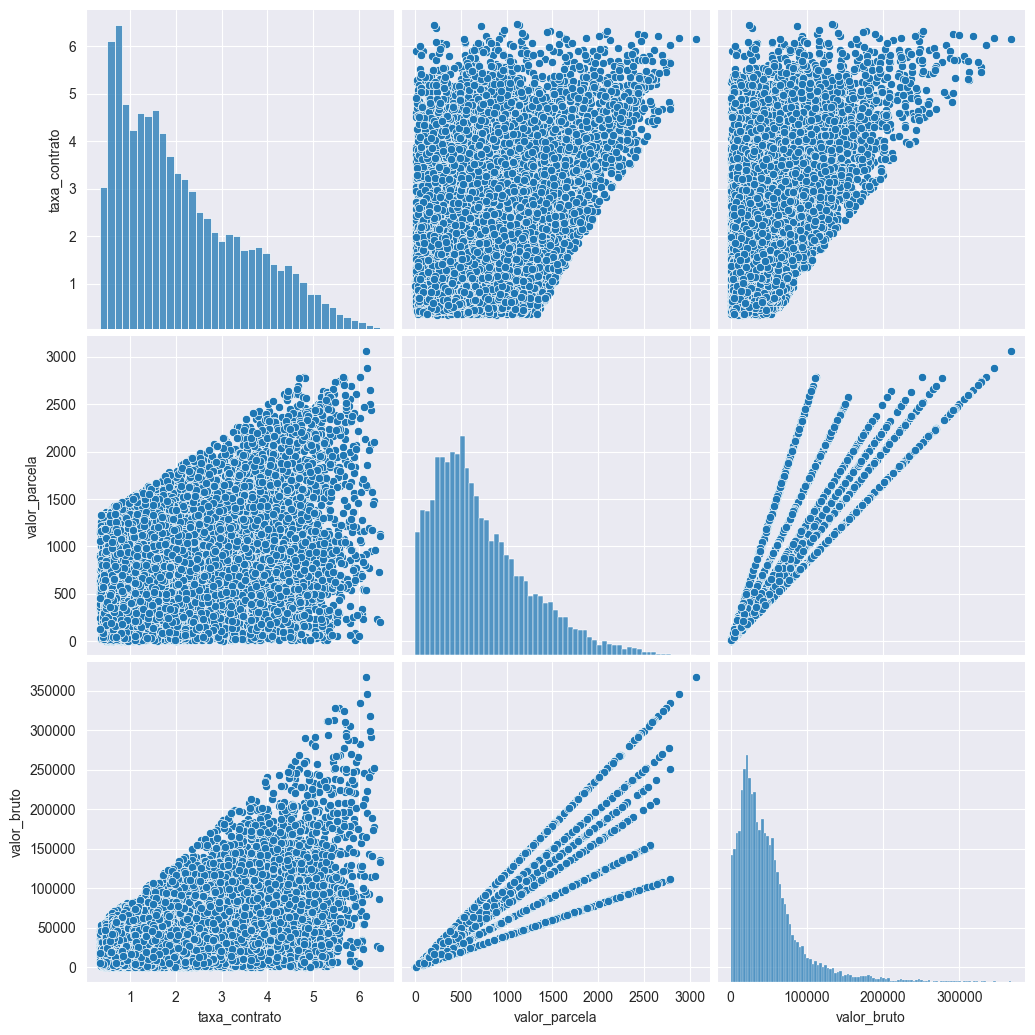

In [9]:
sns.pairplot(X[variaveis_continuas], height=3.5)

Visualmente as variaveis `valor_parcela` e `valor_bruto` uma é a combinação linear da outra

In [10]:
def plot_histogram(data, column, bins=40, ax=None):
    if ax is None:
        ax = plt.gca()
    sns.histplot(data[column], bins=bins, kde=True, ax=ax)

    media = data[column].mean()
    mediana = data[column].median()
    min = data[column].min()
    max = data[column].max()

    ax.axvline(media, color="r", linestyle="--", label=f"Mean: {media:.2f}")
    ax.axvline(mediana, color="g", linestyle="--", label=f"Median: {mediana:.2f}")
    ax.axvline(min, color="y", linestyle="--", label=f"Min: {min:.2f}")
    ax.axvline(max, color="y", linestyle="--", label=f"Max: {max:.2f}")
    ax.legend()

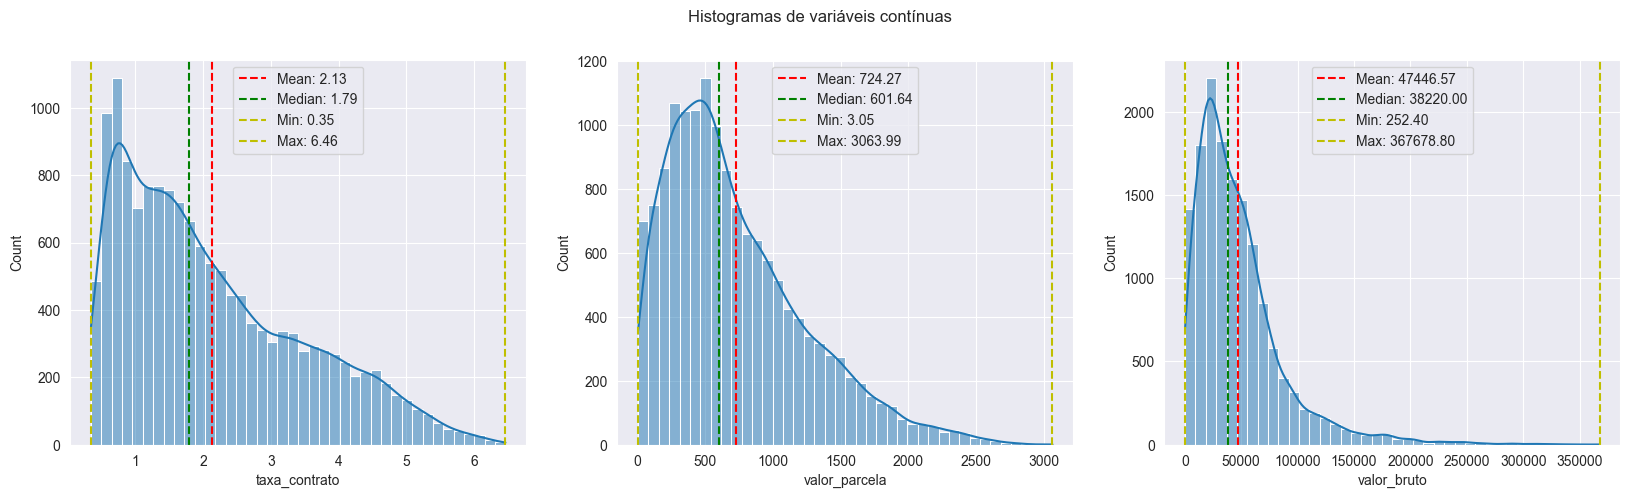

In [11]:
fig, ax = plt.subplots(1, len(variaveis_continuas), figsize=(20, 5))
for column, axis in zip(variaveis_continuas, ax):
    plot_histogram(X, column, bins=40, ax=axis)

plt.suptitle("Histogramas de variáveis contínuas")
plt.show()

Visualmente percebo que possam haver outliers, dado a cauda longa das distribuições (irei validar essa hipotese)

Todas as variáveis contínuas possuem uma cauda positiva (Positive Skewness), __confirmarei abaixo__.

In [12]:
# Calculate skewness for each variable
skew = X[variaveis_continuas].skew()
print("Skewness das variáveis contínuas:")
print(skew)

Skewness das variáveis contínuas:
taxa_contrato   0.7915
valor_parcela   1.0173
valor_bruto     2.1302
dtype: float64


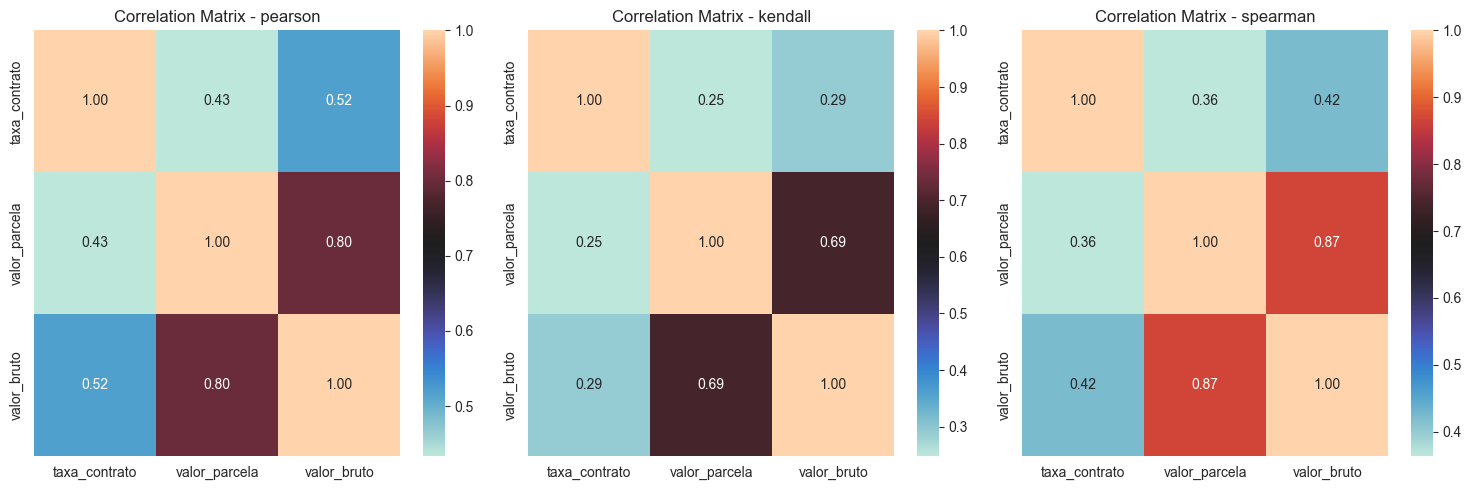

In [13]:
# Create a matplotlib subplot containing heatmaps of the correlation matrix based on three methods
def plot_correlation_heatmap(data, method, ax=None):
    if ax is None:
        ax = plt.gca()
    sns.heatmap(
        data.corr(method=method),
        annot=True,
        fmt=".2f",
        cmap="icefire",
        ax=ax,
    )
    ax.set_title(f"Correlation Matrix - {method}")


fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for method, axis in zip(["pearson", "kendall", "spearman"], ax):
    plot_correlation_heatmap(X[variaveis_continuas], method, ax=axis)

plt.tight_layout()
plt.show()

__Perceba a alta correlação entre `valor_parcela` e `valor_bruto`__

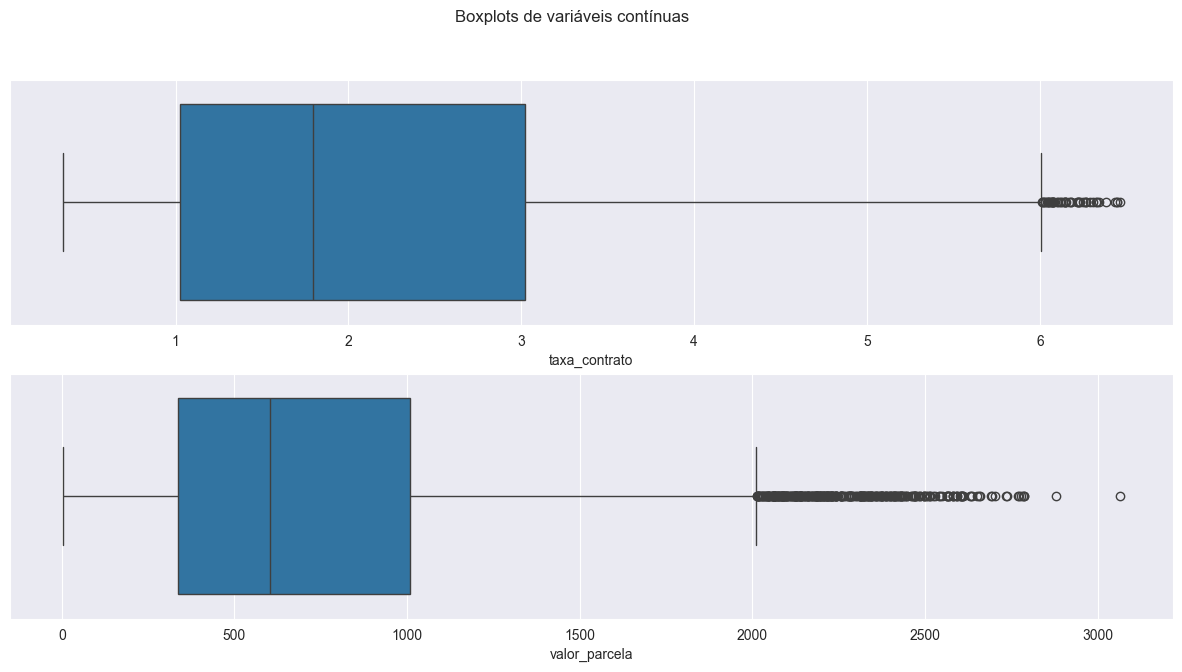

In [14]:
# Create a matplotlib subplot containing boxplots of variabels
def plot_boxplot(data, ax=None):
    if ax is None:
        ax = plt.gca()
    sns.boxplot(x=data, ax=ax)


fig, ax = plt.subplots(2, 1, figsize=(15, 7))
for column, axis in zip(variaveis_continuas, ax):
    plot_boxplot(X[column], ax=axis)

plt.suptitle("Boxplots de variáveis contínuas")
plt.show()

## 3.2 Analisando variáveis discretas

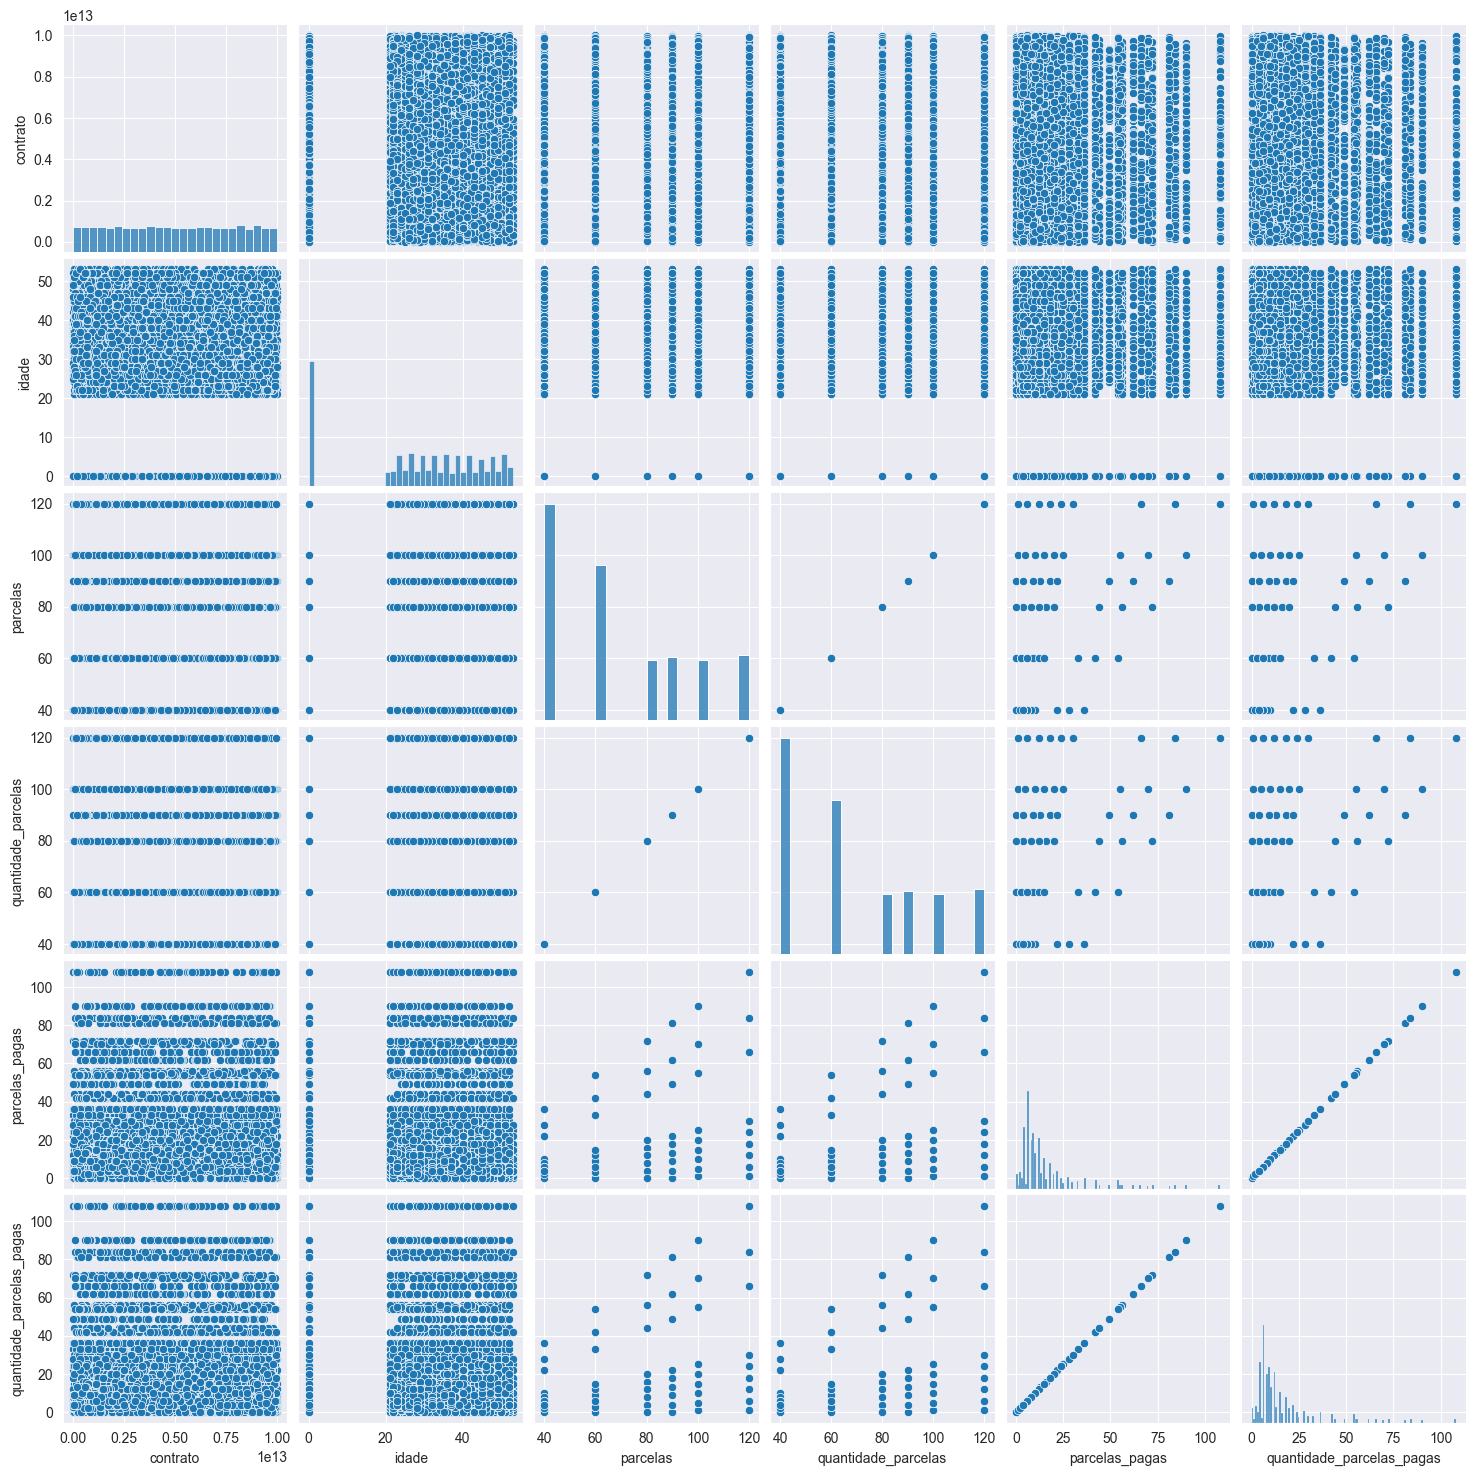

In [15]:
sns.pairplot(X[variaveis_discretas], height=2.5);

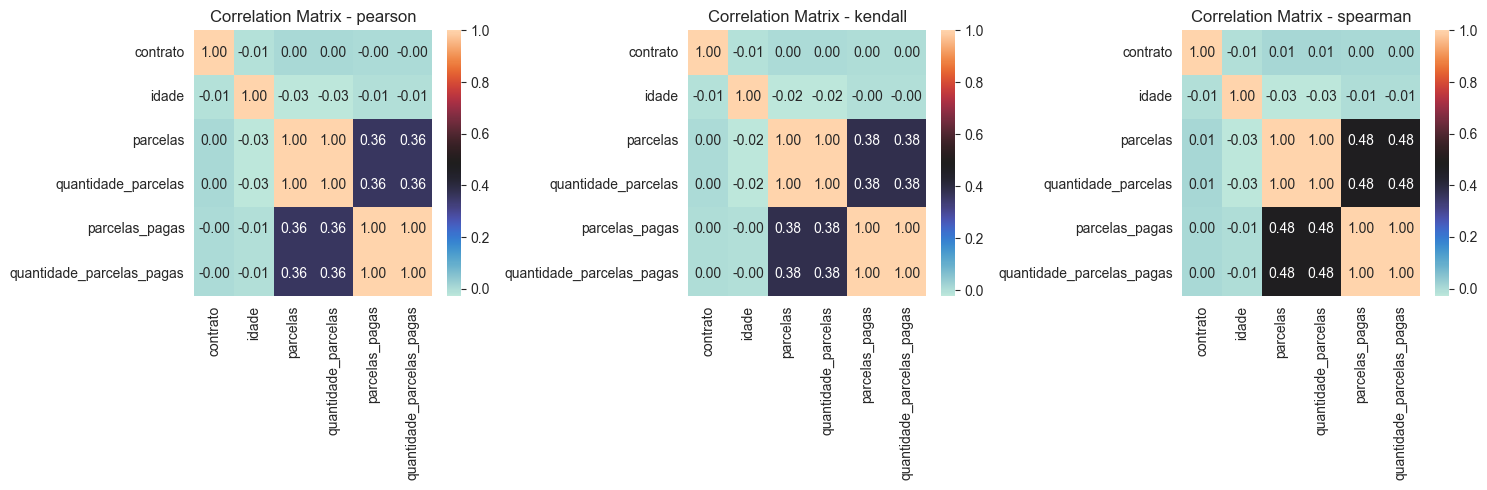

In [16]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for method, axis in zip(["pearson", "kendall", "spearman"], ax):
    plot_correlation_heatmap(X[variaveis_discretas], method, ax=axis)

plt.tight_layout()
plt.show()

##### Não há nenhuma relação que haja um coeficiente com um valor significantemente alto. Dado a suposição de que:


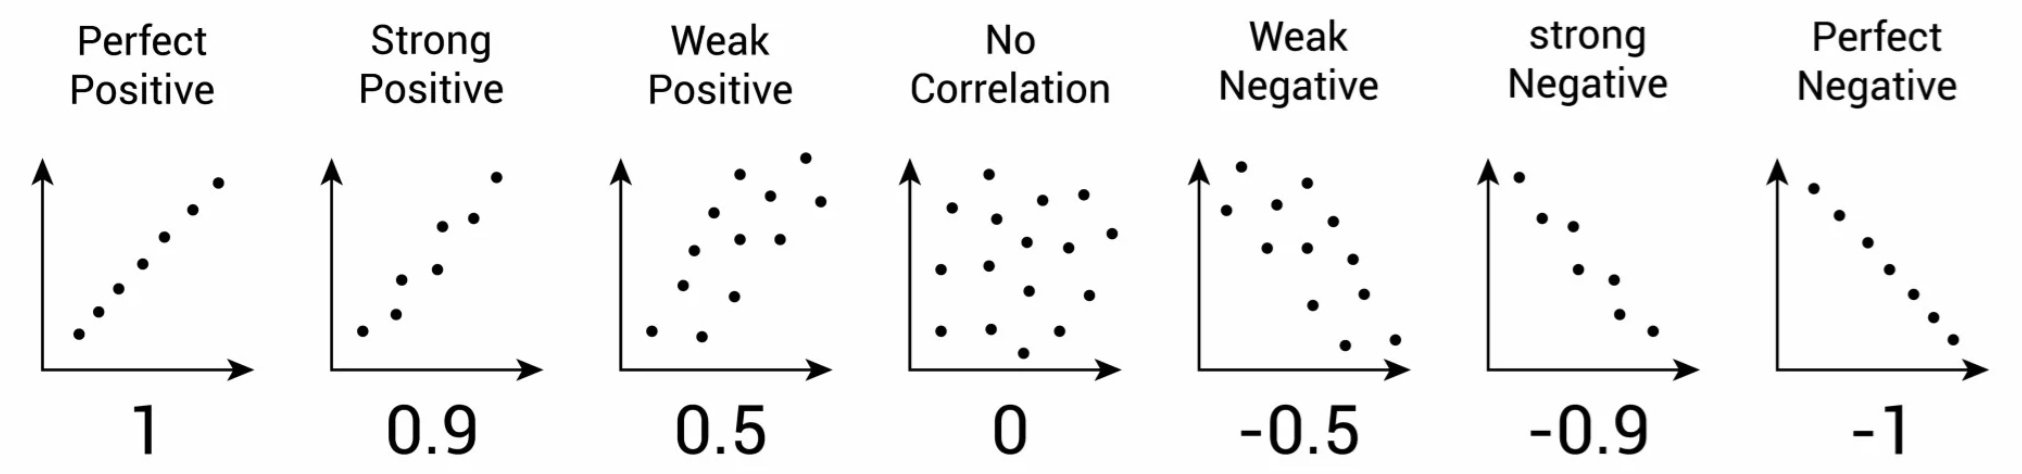

[Image Source](https://www.simplypsychology.org/correlation.html)

# 4. Detecção de outliers


Para a deteccao de outliers irei utilizar a estrategia do IQR Score (Interquantile Range Score). Que e definido como:

$ IQR = Q3 - Q1 $

$ IQR_{Score} = IQR * ± 1.5 $

In [17]:
# Print the number of outiliers for each variable using the IQR method
def print_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    outliers = data[(data[column] < Q1 - 1.5 * IQR) | (data[column] > Q3 + 1.5 * IQR)]
    print(f"{column}: {outliers.shape[0]} outliers")


for column in variaveis_continuas + variaveis_discretas:
    print_outliers(X, column)

taxa_contrato: 48 outliers
valor_parcela: 352 outliers
valor_bruto: 776 outliers
contrato: 0 outliers
idade: 0 outliers
parcelas: 0 outliers
quantidade_parcelas: 0 outliers
parcelas_pagas: 1343 outliers
quantidade_parcelas_pagas: 1343 outliers


Existem alguns outliers que podem ser tratados __(removidos ou suavizados)__. Não irei fazer essa manipulação aqui.

# 5. Seleção de variáveis numéricas

Para a seleção de variáveis irei utilizar o $ VIF $ como técnica

$ VIF(k) = \frac{1}{1 - R_{k}^{2}} $

In [18]:
# Selecionando apenas as variáveis numéricas
X_numeric = X.select_dtypes(include=["float64", "int64"])

# Calculando o VIF para cada variável
vif_data = pd.DataFrame()
vif_data["feature"] = X_numeric.columns
vif_data["VIF"] = [
    variance_inflation_factor(X_numeric.values, i) for i in range(X_numeric.shape[1])
]

# Exibindo as features que poderiam ser removidas (VIF > 5)
features_removidas = vif_data[vif_data["VIF"] > 5]["feature"].tolist()
print("Features que poderiam ser removidas:")
print(features_removidas)

Features que poderiam ser removidas:
['parcelas', 'quantidade_parcelas', 'parcelas_pagas', 'quantidade_parcelas_pagas']


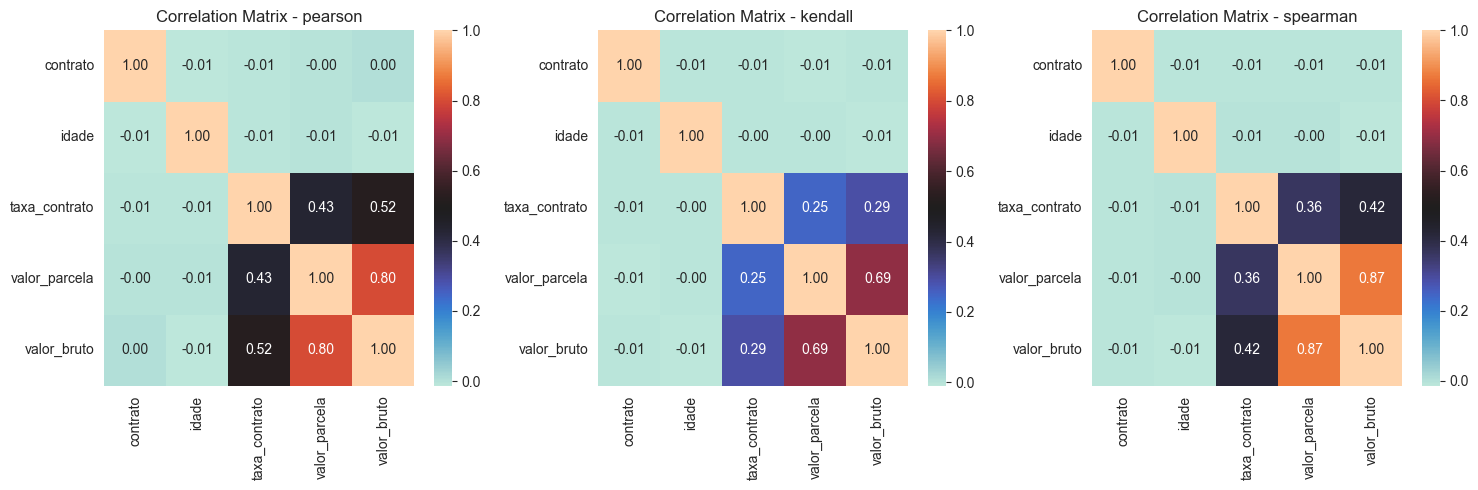

In [19]:
variaveis_numericas_selectionadas = [
    col for col in X_numeric.columns if col not in features_removidas
]
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for method, axis in zip(["pearson", "kendall", "spearman"], ax):
    plot_correlation_heatmap(X[variaveis_numericas_selectionadas], method, ax=axis)

plt.tight_layout()
plt.show()

Perceba que removendo as outras variáveis, agora, os coeficientes são bem menores

# 5. Modelos de previsão


Para a previsão, irei utilizar um modelo de __Prophet__, ele dota uma abordagem baseada em decomposição de séries temporais, onde a série é modelada como a soma de várias componentes __(tendência, sazonalidade, e feriados/eventos especiais)__.

In [20]:
dataset = dataset[X.columns.tolist() + y.columns.tolist()]
dataset = dataset.groupby("data_operacao", as_index=False).agg(
    {"operacao": "count", "valor_principal": "sum"}
)

In [21]:
dataset["data_operacao"] = pd.to_datetime(dataset["data_operacao"])
dataset = dataset.sort_values("data_operacao")
dataset = dataset.resample("D", on="data_operacao").sum().reset_index()
dataset.head()

,data_operacao,operacao,valor_principal
0,2019-01-01,6,107663.7700
1,2019-01-02,10,226089.4800
2,2019-01-03,12,210935.8400
3,2019-01-04,7,85949.5700
4,2019-01-05,6,95787.2400


In [22]:
def train_prophet_model(data, target_column, forecast_days=730):
    data = data.rename(columns={"data_operacao": "ds", target_column: "y"})
    data = data[["ds", "y"]]
    model = Prophet()
    model.fit(data)
    future = model.make_future_dataframe(periods=forecast_days)
    forecast = model.predict(future)
    return model, forecast


def plot_prophet_forecast(model, forecast, ax=None):
    if ax is None:
        ax = plt.gca()
    model.plot(forecast, ax=ax)
    ax.set_title("Prophet Forecast")


def plot_real_vs_forecast(data, forecast, target_column, ax=None):
    if ax is None:
        ax = plt.gca()
    ax.plot(data["data_operacao"], data[target_column], label="Real")
    ax.plot(forecast["ds"], forecast["yhat"], label="Forecast")
    ax.set_title("Real vs Forecast")
    ax.legend()


def calculate_smape(y_true, y_pred):
    return (
        100
        / len(y_true)
        * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))
    )

- Equação do SMAPE (ele é adequado em relação ao tradicional MAPE):

    $ SMAPE = \frac{100\%}{n} \sum_{t=1}^{n} \frac{|F_t - A_t|}{(|A_t| + |F_t|)/2} $

17:04:52 - cmdstanpy - INFO - Chain [1] start processing
17:04:52 - cmdstanpy - INFO - Chain [1] done processing


SMAPE: 25.92


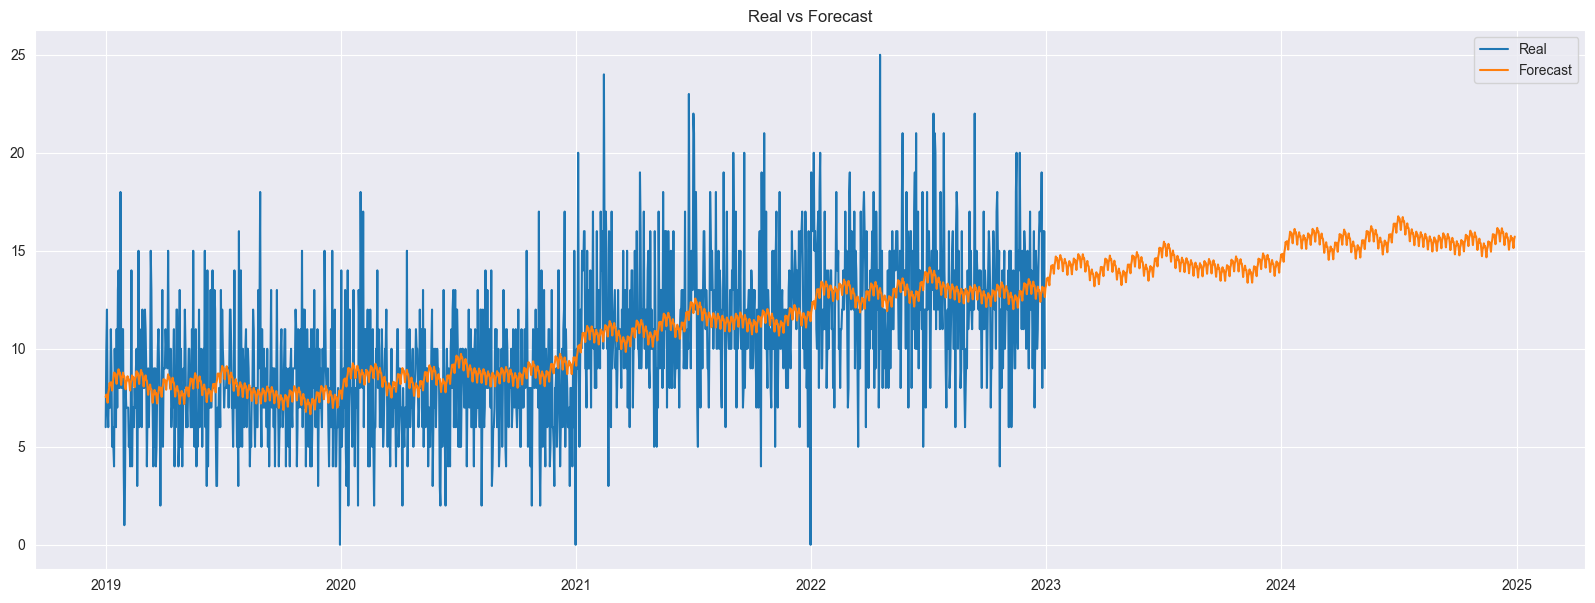

In [23]:
model, forecast = train_prophet_model(dataset, "operacao")
smape = calculate_smape(dataset["operacao"], forecast["yhat"])
print(f"SMAPE: {smape:.2f}")

fig, ax = plt.subplots(1, 1, figsize=(20, 7))
plot_real_vs_forecast(dataset, forecast, "operacao", ax=ax)
plt.show()

17:04:53 - cmdstanpy - INFO - Chain [1] start processing
17:04:53 - cmdstanpy - INFO - Chain [1] done processing


SMAPE: 29.86


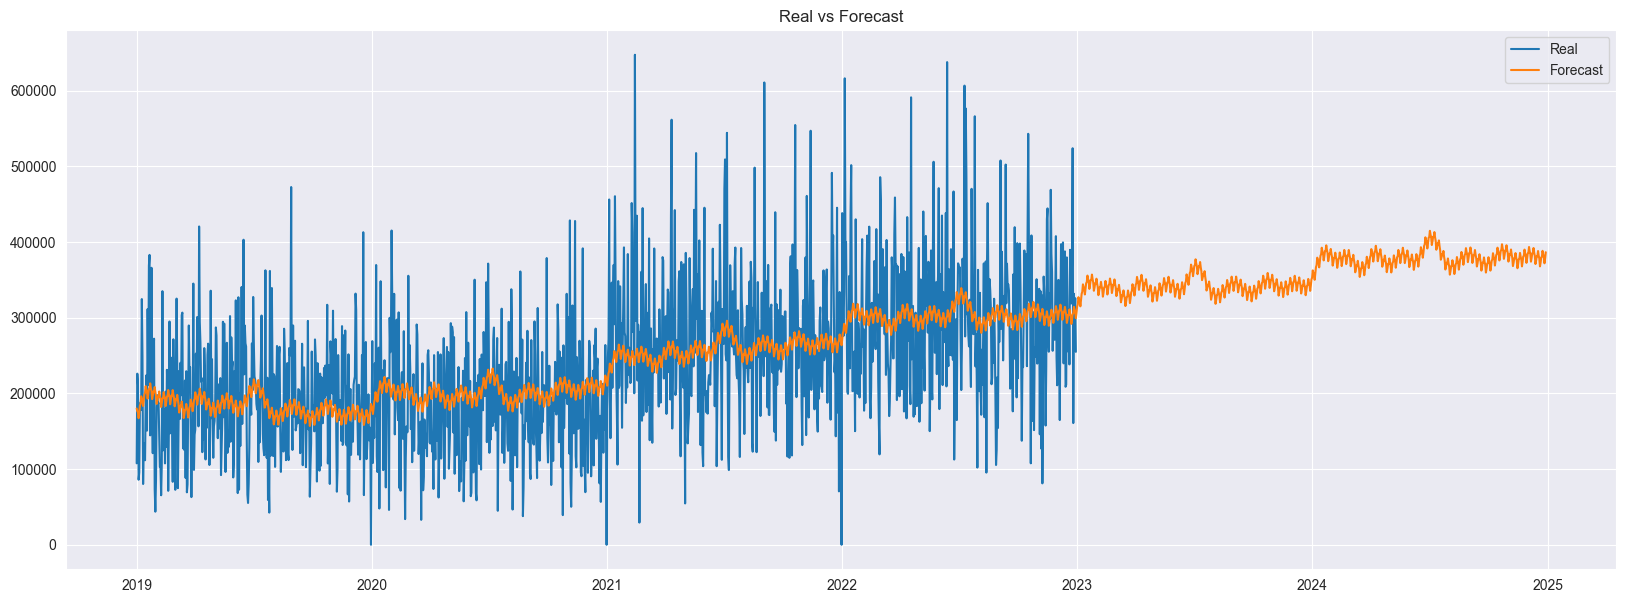

In [24]:
model, forecast = train_prophet_model(dataset, "valor_principal")
smape = calculate_smape(dataset["valor_principal"], forecast["yhat"])
print(f"SMAPE: {smape:.2f}")

fig, ax = plt.subplots(1, 1, figsize=(20, 7))
plot_real_vs_forecast(dataset, forecast, "valor_principal", ax=ax)
plt.show()